<a href="https://colab.research.google.com/github/Aprilhuu/Facial-micro-expression-analysis-in-remote-chat/blob/main/dataloader/face_detection_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CSC420 Project Face Detection Algorithm

HOG + SVM is used here to perform face detection job.

## Part #1: Image Preprocessing

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain

from skimage import data, color, feature, transform
import skimage.data
from sklearn.datasets import fetch_lfw_people
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor

In [26]:
# Fetch faces and make sure they are at required size
faces = fetch_lfw_people(slice_=(slice(70, 195, None), slice(63, 188, None)))
positive_patches_large = faces.images
dim = (positive_patches_large.shape[0], 48, 48)
positive_patches = np.zeros(dim)
print(positive_patches.shape)
print(positive_patches_large.shape)

for n,i in enumerate(positive_patches_large):
    positive_patches[n,:,:] = resize(positive_patches_large[n,:,:], (dim[1], dim[2]), anti_aliasing=True)

positive_patches.shape

(13233, 48, 48)
(13233, 62, 62)


(13233, 48, 48)

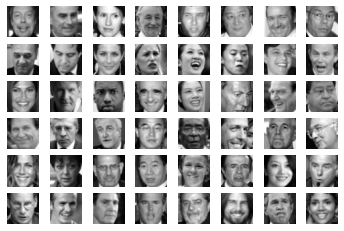

In [27]:
fig, ax = plt.subplots(6, 8)
for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(positive_patches[200 * i], cmap='gray')
    ax_i.axis('off')

In [28]:
negative_images = ['logo', 'chelsea', 'moon','coffee', 'brick', 'camera', 'text', 'coins', 'horse', 
               'page', 'clock', 'immunohistochemistry',
               'coffee', 'hubble_deep_field']

images = [color.rgb2gray(getattr(data, img_name)()) for img_name in negative_images]

print(len(images))

14


In [29]:
# Function referenced from https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(42000, 48, 48)

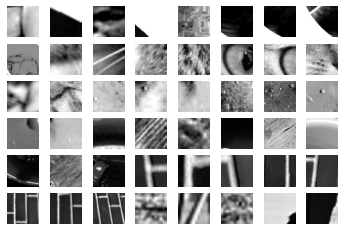

In [30]:
fig, ax = plt.subplots(6, 8)
for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(negative_patches[350 * i], cmap='gray')
    ax_i.axis('off')

In [31]:
X_train = np.array([feature.hog(img)
                    for img in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

## Part #2: Model Training

In [32]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import joblib

In [33]:
model_search = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
model_search.fit(X_train, y_train)
model_search.best_score_
model = model_search.best_estimator_

model.fit(X_train, y_train)

filename = './finalized_face_detection_model.sav'
joblib.dump(model, filename)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

['./finalized_face_detection_model.sav']

## Part #3: Test image face detection

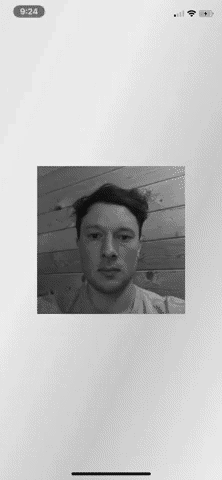

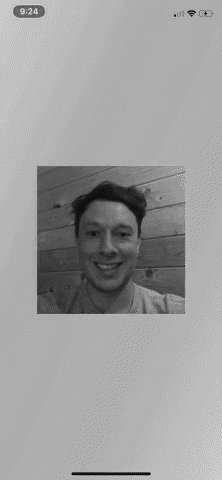

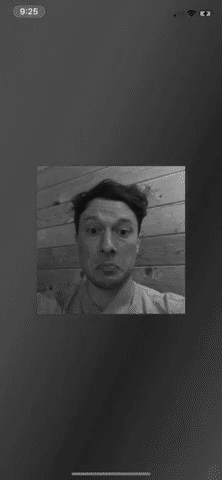

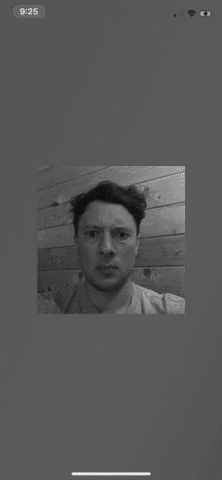

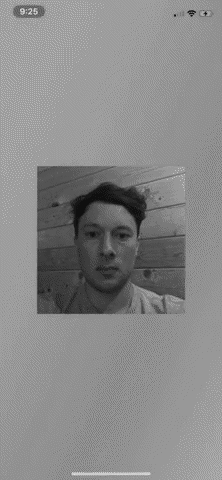

In [34]:
import cv2
from google.colab.patches import cv2_imshow

file_name = 'emotion_app.gif'
dir_name = '/content'
result_dir = '/content/detection_result'
image_size = (48, 48)

def sample_video(file_path, sampling_rate=20):
    # Opens the Video file
    videofile= cv2.VideoCapture(file_path)
    i=0
    frames_list = []
    while(videofile.isOpened()):
        ret, frame = videofile.read()
        if ret == False:
            break
        if i % sampling_rate == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames_list.append(gray)
        i+=1

    videofile.release()
    cv2.destroyAllWindows()
    return frames_list

# frames = sample_video(f"{dir_name}/{file_name}", 10)
frames = sample_video(f"{dir_name}/{file_name}", 50)

for frame in frames:
  # Display the resulting frame
  cv2_imshow(frame)


In [35]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   x_step=2, y_step=10, scale=2.0):
    for (k, resized) in enumerate(transform.pyramid_gaussian(img, downscale=scale)):
      # if the image is smaller than filter size, break from the loop
      if resized.shape[0] < image_size[0] or resized.shape[1] < image_size[1]:
        break
      N_i, N_j = (int(s) for s in patch_size)

      for i in range(0, resized.shape[0] - N_i, x_step):
          for j in range(0, resized.shape[1] - N_i, y_step):
              patch = resized[i:i + N_i, j:j + N_j]
              yield (i, j), patch, scale**k

In [36]:
# Modified from Malisiewicz et al. https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, confidence, overlapThresh=0.4, reversed=False):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by confidence score
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    if reversed:
        idxs = np.argsort(-confidence.flatten())
    else:
        idxs = np.argsort(confidence.flatten())
		
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        if reversed:
            idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap == 1.0)[0])))
        else:
            idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int"), confidence[pick]


In [37]:
def process_frame(frame_seq, video_name, num_person=1):
    count = 0
    for one_frame in frame_seq:
        frame_blurred = cv2.blur(one_frame, (6, 6))
        indices, patches, scale_levels = zip(*sliding_window(frame_blurred))
        patches_hog = np.array([feature.hog(patch) for patch in patches])
        model = joblib.load("./finalized_face_detection_model.sav")

        labels = model.predict(patches_hog)
        candidate_boxes_idx = np.argwhere(labels > 0)
        candidate_boxes = []
        confidence_score = []

        indices = np.array(indices)
        scale_levels = np.array(scale_levels)

        for k in candidate_boxes_idx:
            confidence = model.decision_function(patches_hog[k])
            if confidence > 2:
                scale = scale_levels[k]
                x = indices[k][0][0] * scale
                y = indices[k][0][1] * scale
                corners = (x, y, x +  image_size[0] * scale - 1, y +  image_size[1] * scale - 1)
                candidate_boxes.append(corners)
                confidence_score.append(confidence)

        candidate_boxes = np.array(candidate_boxes)
        confidence_score = np.array(confidence_score)

        bounding_boxes, cs = non_max_suppression_fast(candidate_boxes, confidence_score, 0.4)
        if bounding_boxes.shape[0] > 1:
            bounding_boxes, cs = non_max_suppression_fast(bounding_boxes, cs, reversed=True)

        idxs = np.argsort(-cs.flatten())
        num_of_boxes = min(num_person, len(bounding_boxes))

        intra_frame_count = 0
        for i in range(num_of_boxes):
            coord = bounding_boxes[idxs[i]].flatten()
            crop_image = one_frame[coord[0]:coord[2], coord[1]:coord[3]]
            resized = cv2.resize(crop_image, image_size, interpolation = cv2.INTER_AREA)
            cv2_imshow(resized)
            print(resized.shape)
            save_file_name = video_name.split(".")[0] + "_" + str(count) + "_" + str(intra_frame_count) + ".jpg"
            cv2.imwrite(result_dir + "/" + save_file_name, resized)
            intra_frame_count += 1

        count += 1


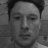

(48, 48)


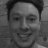

(48, 48)


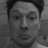

(48, 48)


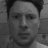

(48, 48)


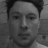

(48, 48)


In [38]:
process_frame(frames, video_name=file_name)

# Archived Code

In [39]:
import os
from torchvision.datasets.utils import download_and_extract_archive

# download
data_dir = "./data"
data_name = "FER2013"
if not os.path.exists(f"{data_dir}/{data_name}"):
  print("Start downloading FER2013!")
  url = 'https://github.com/Aprilhuu/Facial-micro-expression-analysis-in-remote-chat/raw/main/data/FER2013.zip'
  download_and_extract_archive(url, f"{data_dir}", f"{data_dir}", filename=data_name + '.zip')

Start downloading FER2013!


Extracting ./data/FER2013.zip to ./data

